# Assignment 3: Generative Modeling with [VQ-VAE](https://arxiv.org/pdf/1711.00937.pdf)

In this task you will:

- implement a [VQ-VAE](https://arxiv.org/pdf/1711.00937.pdf) model (5pts),
- train it on the MNIST dataset (1pt),
- analyze its dictionary (1pt) and latent space (1pts),
- use it to generate new data (2pts).

First, let us carefully read the [original paper](https://arxiv.org/pdf/1711.00937.pdf) to understand the general idea. Please - be sure that you understand the general overview of the model (Subsection 3.1) and how its loss function is implemented (Subsection 3.2).

We will diverge from the ideas presented in the paper starting from the prior, as we will use a much simpler prior than [PixelCNN](https://arxiv.org/abs/1606.05328) used by the authors. Instead, we will concentrate more on a standard analysis of the VQ-VAE model embeddings - including basic analysis of the latent space and its dictionary. We will conclude with simple implementation of the prior using Bayesian Gaussian Mixture and generation of a new data.

## Data overview

We will use a subset of MNIST dataset. Instead of all digits we will only use data for `FIRST_DIGIT` and `SECOND_DIGIT`. For this task, keep predefined `0` and `4`, but you can later check your solution for other digits.

We will additionally resize it to the shape of `(BATCH_SIZE, 1, 24, 24)` by cutting `CUT=2` pixels from each side of each image. Please notice that data is rescaled to `[-1, 1]` interval.

The following code provides:
- `train_x` and `val_x` - train set and validation set for training of your model (`MNIST` narrowed down to `FIRST_DIGIT` and `SECOND_DIGIT` classes),
- `train_y` and `val_y` - train labels and validation labels indicating if given example has `FIRST_DIGIT` class,
- appropriate training and validation dataloaders.

**CAUTION:** for the purpose of this exercise do not modify `FIRST_DIGIT` and `SECOND_DIGIT`. Fell free to modify datasets and dataloaders, eg. to include additional augmentations but its not necessary and will not affect the final grade.

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

!pip install lightning


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

MNIST_SIZE = 28
CUT = 2

FIRST_DIGIT = 0
SECOND_DIGIT = 4

train_dataset = torchvision.datasets.MNIST(
    root=r'./mnist/',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

val_dataset = torchvision.datasets.MNIST(
    root=r'./mnist/',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)

full_train_x = 2 * (train_dataset.data.float() / 255. - 0.5)[:, :, CUT:-CUT][:, CUT:-CUT]
full_val_x = 2 * (val_dataset.data.float() / 255. - 0.5)[:, :, CUT:-CUT][:, CUT:-CUT]

full_train_y = train_dataset.targets
full_val_y = val_dataset.targets

selected_digits_bool_train = torch.logical_or(
    full_train_y == FIRST_DIGIT,
    full_train_y == SECOND_DIGIT
)
selected_digits_bool_val = torch.logical_or(
    full_val_y == FIRST_DIGIT,
    full_val_y == SECOND_DIGIT
)

train_x = full_train_x[selected_digits_bool_train].reshape(
    -1,
    1,
    MNIST_SIZE - 2 * CUT,
    MNIST_SIZE - 2 * CUT,
).to(DEVICE)
val_x = full_val_x[selected_digits_bool_val].reshape(
    -1,
    1,
    MNIST_SIZE - 2 * CUT,
    MNIST_SIZE - 2 * CUT,
).to(DEVICE)

train_y = full_train_y[selected_digits_bool_train] == FIRST_DIGIT
val_y = full_val_y[selected_digits_bool_val] == FIRST_DIGIT

train_dataloader = DataLoader(train_x, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_x, batch_size=BATCH_SIZE, shuffle=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

100%|██████████| 9912422/9912422 [00:00<00:00, 352178354.17it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34007774.80it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 155005746.61it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18585881.72it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



## Model Implementation (5pts)

### Encoder Model (1pt)

Implement an `Encoder` module with an architecture of your choice. Its constructor should accept `latent_dim` - the size of a latent space, and should output a feature map of size `(BATCH_SIZE, latent_dim, 3, 3)`.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=latent_dim, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

### Decoder Model (1pt)

Implement a `Decoder` model with an architecture of your choice. It should accept a feature map of shape `(BATCH_SIZE, embedding_dim, H, W)` and output a batch of reconstructed images.

**Hint**: as pixel values are rescaled to a `[-1, 1]` interval, consider usage of a [`tanh`](https://pytorch.org/docs/stable/generated/torch.nn.functional.tanh.html) activation.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.convT1 = nn.ConvTranspose2d(in_channels=embedding_dim, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.convT1(x))
        x = F.relu(self.convT2(x))
        x =torch.tanh(self.convT3(x))
        return x

### VectorQuantizer Module (2pts)

In this part you will implement a `VectorQuantizer` module from the [VQ-VAE paper](https://arxiv.org/pdf/1711.00937.pdf). Its constructor should accept:

- `num_embeddings` - the size of your dictionary,
- `embedding_dim` - the size of your latent space,
- `beta` - the rate for the commitment loss.

Its `forward` function should accept an `input` tensor of shape `(BATCH_SIZE, embedding_dim, H, W)` and output at least 5 tensors:

- `quantized_latent` - a tensor of size `(BATCH_SIZE, embedding_dim, H, W)` where for each example `n` and spatial position `h, w`, `quantized_latent[n, :, h, w]` is a matched element from your dictionary for the embedding vector `input[n, :, h, w]`. This tensor will be later fed to your `Decoder` model,
- `q_loss` - a dictionary learning loss (a second term of the loss function defined in the equation (3) in the [original paper](https://arxiv.org/pdf/1711.00937.pdf)),
- `e_loss` - a commitment loss (a third term of the loss function defined in the equation (3) in the [original paper](https://arxiv.org/pdf/1711.00937.pdf)),
- `vq_loss = q_loss + beta * e_loss` - full `VectorQuantizer` loss,
- `matched_indices` - a tensor of shape `(BATCH_SIZE, H, W)` where `matched_indices[n, h, w]` stores the information about which dictionary element was matched to the `input[n, :, h, w]` embedding vector of the `n-th` image in your batch.

As matching performed by a `VectorQuantizer` is not differentiable - your model should implement a [straight-through](https://arxiv.org/abs/1308.3432) gradient estimator, that will pass the gradient of the loss from `quantized_latent` directly to the `input` tensor.

**Caution**: according to the Subsection 3.2 of the [original paper](https://arxiv.org/pdf/1711.00937.pdf) `quantized_latent` should not be modified using the training gradient from the `Decoder`. It is only trained by `q_loss` and `e_loss`. If your `quantized_latent` is modified by a gradient from your `Decoder` you will **lose 1pt**.


**Hint:** [here](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax) you may find a really simple implementation of a *straight-through* estimator for a Gumbel Softmax.



In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, input):

        distances = torch.linalg.vector_norm(input.movedim(1, -1).unsqueeze(-2) - self.embedding.weight, dim=-1) # shape (BATCH_SIZE, H, W, num_embeddings)
        matched_indices = torch.argmin(distances, dim=-1) # shape (BATCH_SIZE, H, W)
        quantized_latent = self.embedding(matched_indices) # shape (BATCH_SIZE, H, W, embedding_dim)
        quantized_latent = quantized_latent.movedim(-1, 1) # shape (BATCH_SIZE, embedding_dim, H, W)

        q_loss = F.mse_loss(quantized_latent, input.detach())
        e_loss = F.mse_loss(quantized_latent.detach(), input)
        vq_loss = q_loss + self.beta * e_loss

        quantized_latent = input + (quantized_latent - input).detach()

        return quantized_latent, q_loss, e_loss, vq_loss, matched_indices

### Final Model (1pt)

Implement a `VQ-VAE` model that will combine `Encoder`, `VectorQuantizer` and `Decoder` models. Its constructor should accept at least:

- `embedding_dim` - the size of a latent space of your model,
- `num_embeddings` - the size of a dictionary of your `VectorQuantizer`,
- `beta` - the rate of a commitment loss of your `VectorQuantizer`.

and instantiate appropriate `Encoder`, `VectorQuantizer` and `Decoder` modules.

Additionally you should implement:
- all methods required for training and validation of your model using `lightning` module, use `mse_loss` as a reconstruction loss of your auto-encoder. Reconstruction loss should be logged on both training and validation data.

- an `encode` method that given a batch of images, returns a `latent` tensor - an output of `Encoder` as well as `quantized_latent` and `matched_indices` tensors - result of application of a `VectorQuantizer` to the `latent` tensor,
- a `decode` method that given a batch of latent vectors, will quantize them using `VectorQuantizer` and feed them to the decoder returning `reconstructed_images` tensor. This method should additionally return `matched_indices` from the quantization procedure.

In [ ]:
import lightning.pytorch as pl


class Model(pl.LightningModule):
    def __init__(self, embedding_dim, num_embeddings, beta):
        super(Model, self).__init__()

        # Initialize the encoder, vector quantizer and decoder
        self.encoder = Encoder(embedding_dim)
        self.vector_quantizer = VectorQuantizer(num_embeddings, embedding_dim, beta)
        self.decoder = Decoder(embedding_dim)

        self.reconstruction_loss = nn.MSELoss()

    def forward(self, x):
        latent, _, _,  = self.encode(x)
        reconstructed_x, _, vq_loss = self.decode(latent)
        return reconstructed_x, vq_loss

    def encode(self, x):
        latent = self.encoder(x)
        quantized_latent, q_loss, e_loss, vq_loss, matched_indices = self.vector_quantizer(latent)
        #self.log_dict({'q_loss': q_loss, 'e_loss': e_loss, 'vq_loss': vq_loss}, on_step=True, on_epoch=True)
        return latent, quantized_latent, matched_indices

    def decode(self, latent):
        quantized_latent, _, _, vq_loss, matched_indices = self.vector_quantizer(latent)
        reconstructed_x = self.decoder(quantized_latent)
        return reconstructed_x, matched_indices, vq_loss

    def training_step(self, batch, batch_idx):
        x = batch
        reconstructed_x, vq_loss = self(x)
        recon_loss = self.reconstruction_loss(reconstructed_x, x)
        loss = recon_loss + vq_loss
        self.log('recon_loss', recon_loss, on_step=True, on_epoch=True)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch
        reconstructed_x, vq_loss = self(x)
        recon_loss = self.reconstruction_loss(reconstructed_x, x)
        loss = recon_loss + vq_loss
        self.log('recon_loss', recon_loss, on_step=True, on_epoch=True)
        self.log('val_loss', loss, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

## Model Training (1pt)

Instantiate and train your model on the prepared subset of `MNIST` data. Training will be considered as succesful if you achieve `<0.05` reconstruction loss on the validation data.

**Hint:** `num_embeddings` from range `[32, 64]` should be enough for a succesful training. The authors of [original paper](https://arxiv.org/pdf/1711.00937.pdf) suggest to use `beta=0.25`.

In [ ]:
beta = 0.25


model = Model(128, 64, 0.25) # TODO

In [ ]:
MAX_EPOCHS = 50

trainer = pl.Trainer(
        max_epochs=MAX_EPOCHS,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                | Type            | Params
--------------------------------------------------------
0 | encoder             | Encoder         | 92.7 K
1 | vector_quantizer    | VectorQuantizer | 8.2 K 
2 | decoder             | Decoder         | 221 K 
3 | reconstruction_loss | MSELoss         | 0     
--------------------------------------------------------
322 K     Trainable params
0         Non-trainable params
322 K     Total params
1.291     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name                | Type            | Params
-----------------------------------------------

Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
trainer.validate(dataloaders=val_dataloader)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=49-step=18400.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=49-step=18400.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=49-step=18400.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Lo

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     recon_loss_epoch      │    0.15481752157211304    │
│      val_loss_epoch       │    0.3503139317035675     │
└───────────────────────────┴───────────────────────────┘

[{'recon_loss_epoch': 0.15481752157211304,
  'val_loss_epoch': 0.3503139317035675}]

## Dictionary Visualization (1pt)

Visualize a dictionary learnt by your model. In order to solve your task you shoud:

1. Reshape your dictionary tensor to shape `(num_embeddings, embedding_dim, 1, 1)` and decode it using your VQ-VAE model.
2. Visualize each reconstructed dictionary element on an image grid.

Does the dictionary elements make a visual sense?

**Note on grading**: You can get extra points if you compare the distribution of occurences of a given dictionary element between the `FIRST_DIGIT` and `SECOND_DIGIT` in your training data.

64 8


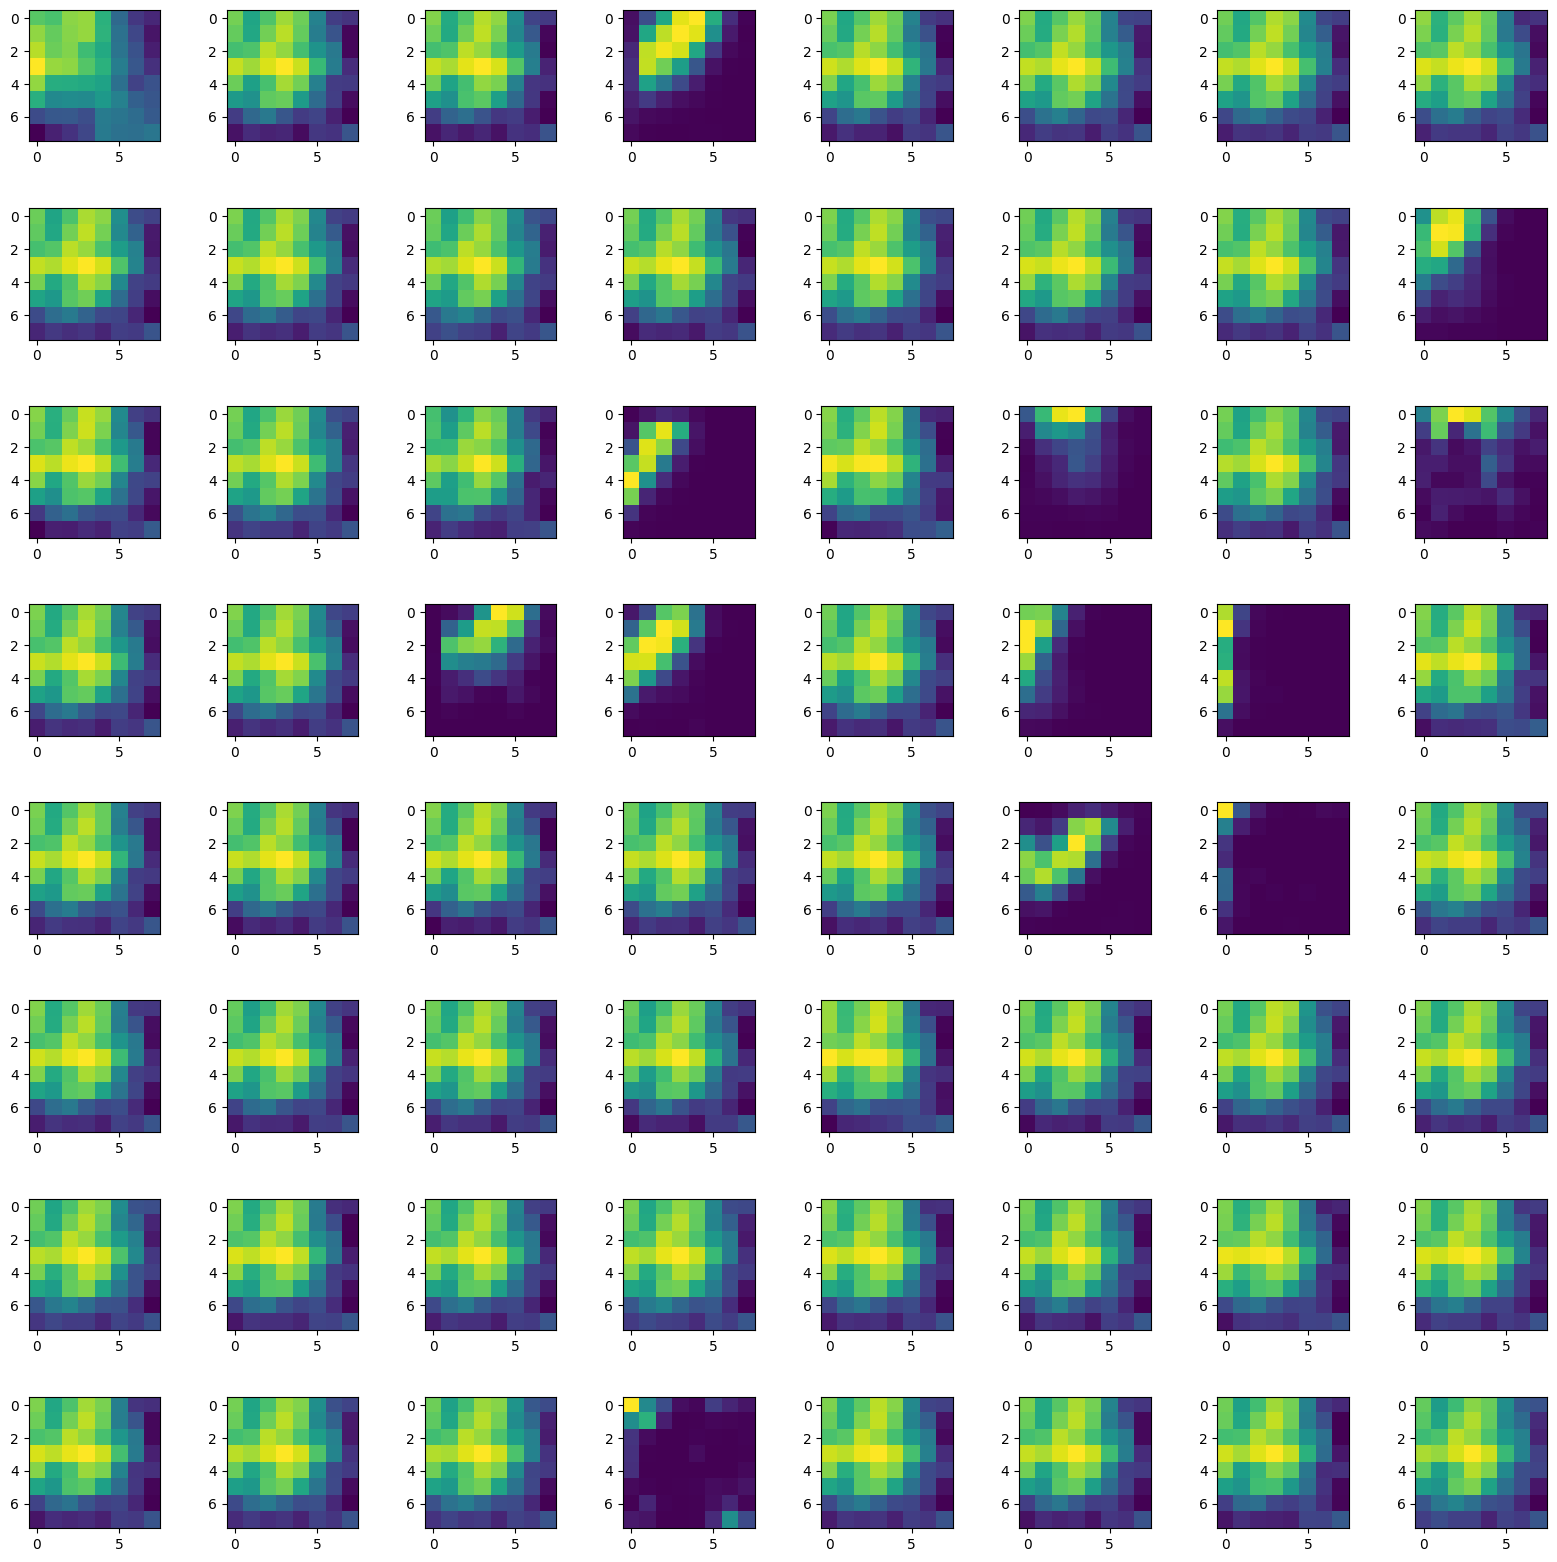

In [ ]:
import numpy as np

emb = model.vector_quantizer.embedding.weight
emb = emb.view(*emb.shape, 1, 1)
rec_d, matched_indices, _ = model.decode(emb)
rec_d = rec_d.detach().cpu().numpy()
r_n = np.sqrt(rec_d.shape[0]).astype(int)
print(rec_d.shape[0], r_n)
fig, ax = plt.subplots(r_n, r_n, figsize = (16, 16))
fig.tight_layout()
for a, img in zip(ax.flatten(), rec_d):
  a.imshow(img.squeeze())
plt.show()

Some of them yes. But in my case I probably should use more complicated encoder and decoder becouse my reconstraction loss is above 0.1. But my model can still generate nice number you will see. I would like to write like that.

## Latent Space Visualization (1pt)

In this part you will visualize the latent space of your model. As it usually has more than 3-dimensions that are easy to visualize, we will use [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) dimensionality reduction in order to have a look at the most varying latent dimensions. To solve this subtask you should:

1. Encode `train_x` data to obtain its non-quantized `latent`,
2. Train a [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) model that explains `expected_explained_variance_ratio = 0.99` of `latent` variation. As latent is a 4-dimensional tensor - flatten it across spatial dimensions,
3. Draw 3 scatter plots - with the first and the second, the second and the third, and finally - the third and the fourth projections along principal components trained in the step 2. Visualize digits `FIRST_DIGIT` and `SECOND_DIGIT` with different colors. Use `alpha=0.3` in your scatter plots to get a sense of points density. Each axis should be named with an index of a principal component as well as its explained variance ratio.

Can you see any patterns? If not - is it good that your latent cannot discriminate between `FIRST_DIGIT` and `SECOND_DIGIT`? What fraction of all data dimensions is required to explain `expected_explained_variance_ratio` data comparing to the dimensionality?

In [ ]:
from sklearn.decomposition import PCA

model = model.to(DEVICE)
latent, _, _ = model.encode(train_x)

expected_explained_variance_ratio = 0.99
random_state = 0

x = latent.view(latent.shape[0], -1).detach().cpu().numpy()

pca = PCA(svd_solver = 'full', n_components = expected_explained_variance_ratio, random_state = random_state)

compoments = pca.fit_transform(x)

explain_variance = pca.explained_variance_ratio_

In [ ]:
train_y.numpy()

array([ True, False, False, ...,  True, False,  True])

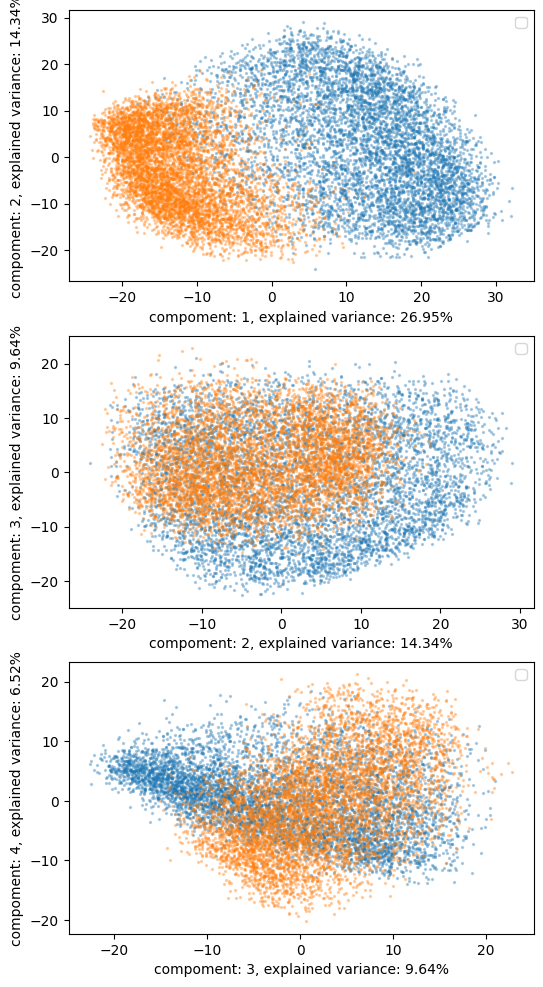

In [ ]:
comp = compoments[:, :4]

fig, ax = plt.subplots(3, 1, figsize = (6, 12))

for i, a in enumerate(ax):
  a.scatter(comp[train_y.numpy(), i], comp[train_y.numpy(), i + 1], alpha = 0.3, s = 2)

  a.scatter(comp[~train_y.numpy(), i], comp[~train_y.numpy(), i + 1], alpha = 0.3, s = 2)

  a.set_xlabel(f'compoment: {i + 1}, explained variance: {round(100 * explain_variance[i], 2)}%')
  a.set_ylabel(f'compoment: {i + 2}, explained variance: {round(100 * explain_variance[i + 1], 2)}%')
  a.legend()

plt.show()

On 1 vs 2 component and 3 vs 4 patterns are nicely visible

## New Data Generation [2pts]

In this part you will generate new data points using your VQ-VAE model. In order to solve this subtask you will:

1. Train a [`BayesianGaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html) model on the [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) transformed data. Use the [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) decomposer from a previous subtask. Use either 2 or 3 `n_components`,
2. Visualize component means of the trained mixture ([`BayesianGaussianMixture.means_`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html)) on 3 [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) plots defined in the step 2 of Latent Space Visualization subtask. Does the learnt mixture make sense?
3. Predict classes of the learnt components using ([`BayesianGaussianMixture.predict`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html)) method and compute confusion matrix of the predicted mixture components with `train_x`. Can you see any interesting patterns? If yes - how would you explain them?
4. Generate `n_samples=36` samples from your mixture, feed them back to the [`PCA.inverse_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) method of your [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) decomposer, reshape it back to the 4-dim tensor with spatial dimensions and decode it using your VQ-VAE model.
5. Visualize the generated samples with their mixture predictions on an 6x6 image grid. Do the generated example resemble original data? Do the mixture predictions correlate with the digit of generated sample?

**Note on grading** in order to get 2pts for this subtask, at least a half of the generated examples should make at least some visual sense (do not worry - this part will be graded gently :) ).

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

bayesian = BayesianGaussianMixture(
    n_components = 2,
    random_state = random_state)

pred = bayesian.fit_predict(compoments)

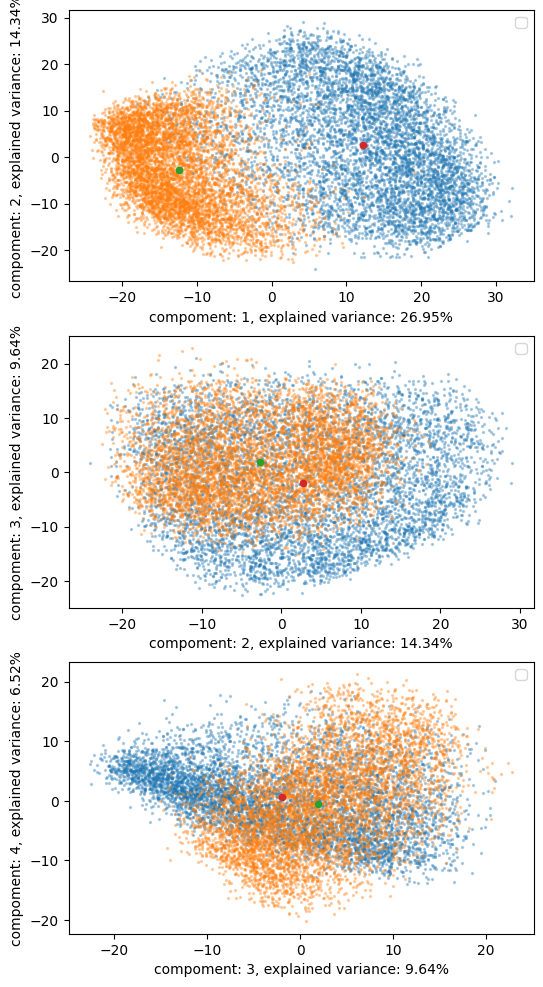

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (6, 12))

for i, a in enumerate(ax):
  a.scatter(comp[train_y.numpy(), i], comp[train_y.numpy(), i + 1], alpha = 0.3, s = 2)

  a.scatter(comp[~train_y.numpy(), i], comp[~train_y.numpy(), i + 1], alpha = 0.3, s = 2)

  a.scatter(bayesian.means_[0, i], bayesian.means_[0, i + 1], s = 20) # mean

  a.scatter(bayesian.means_[1, i], bayesian.means_[1, i + 1], s = 20) # mean2

  a.set_xlabel(f'compoment: {i + 1}, explained variance: {round(100 * explain_variance[i], 2)}%')
  a.set_ylabel(f'compoment: {i + 2}, explained variance: {round(100 * explain_variance[i + 1], 2)}%')
  a.legend()

plt.show()

As we can see this is ok in first plot we have bouth means in the centers of their groups.

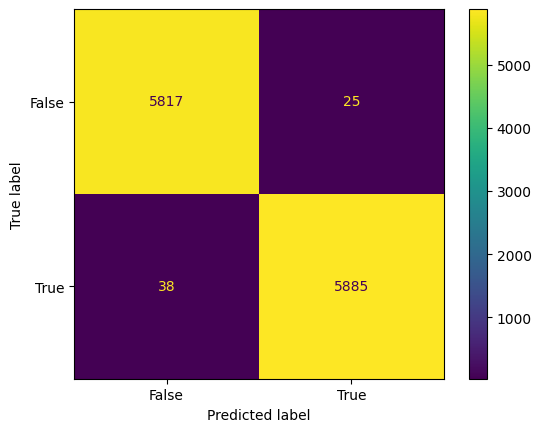

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(train_y, pred)
plt.show()

Results are very good. It means taht our components have fulfilled their task.

In [ ]:
n_samples = 36
samples = bayesian.sample(n_samples)
x_s, y_s = samples[0], samples[1]
y_s = np.array([4 if v == 0 else 0 for v in y_s])

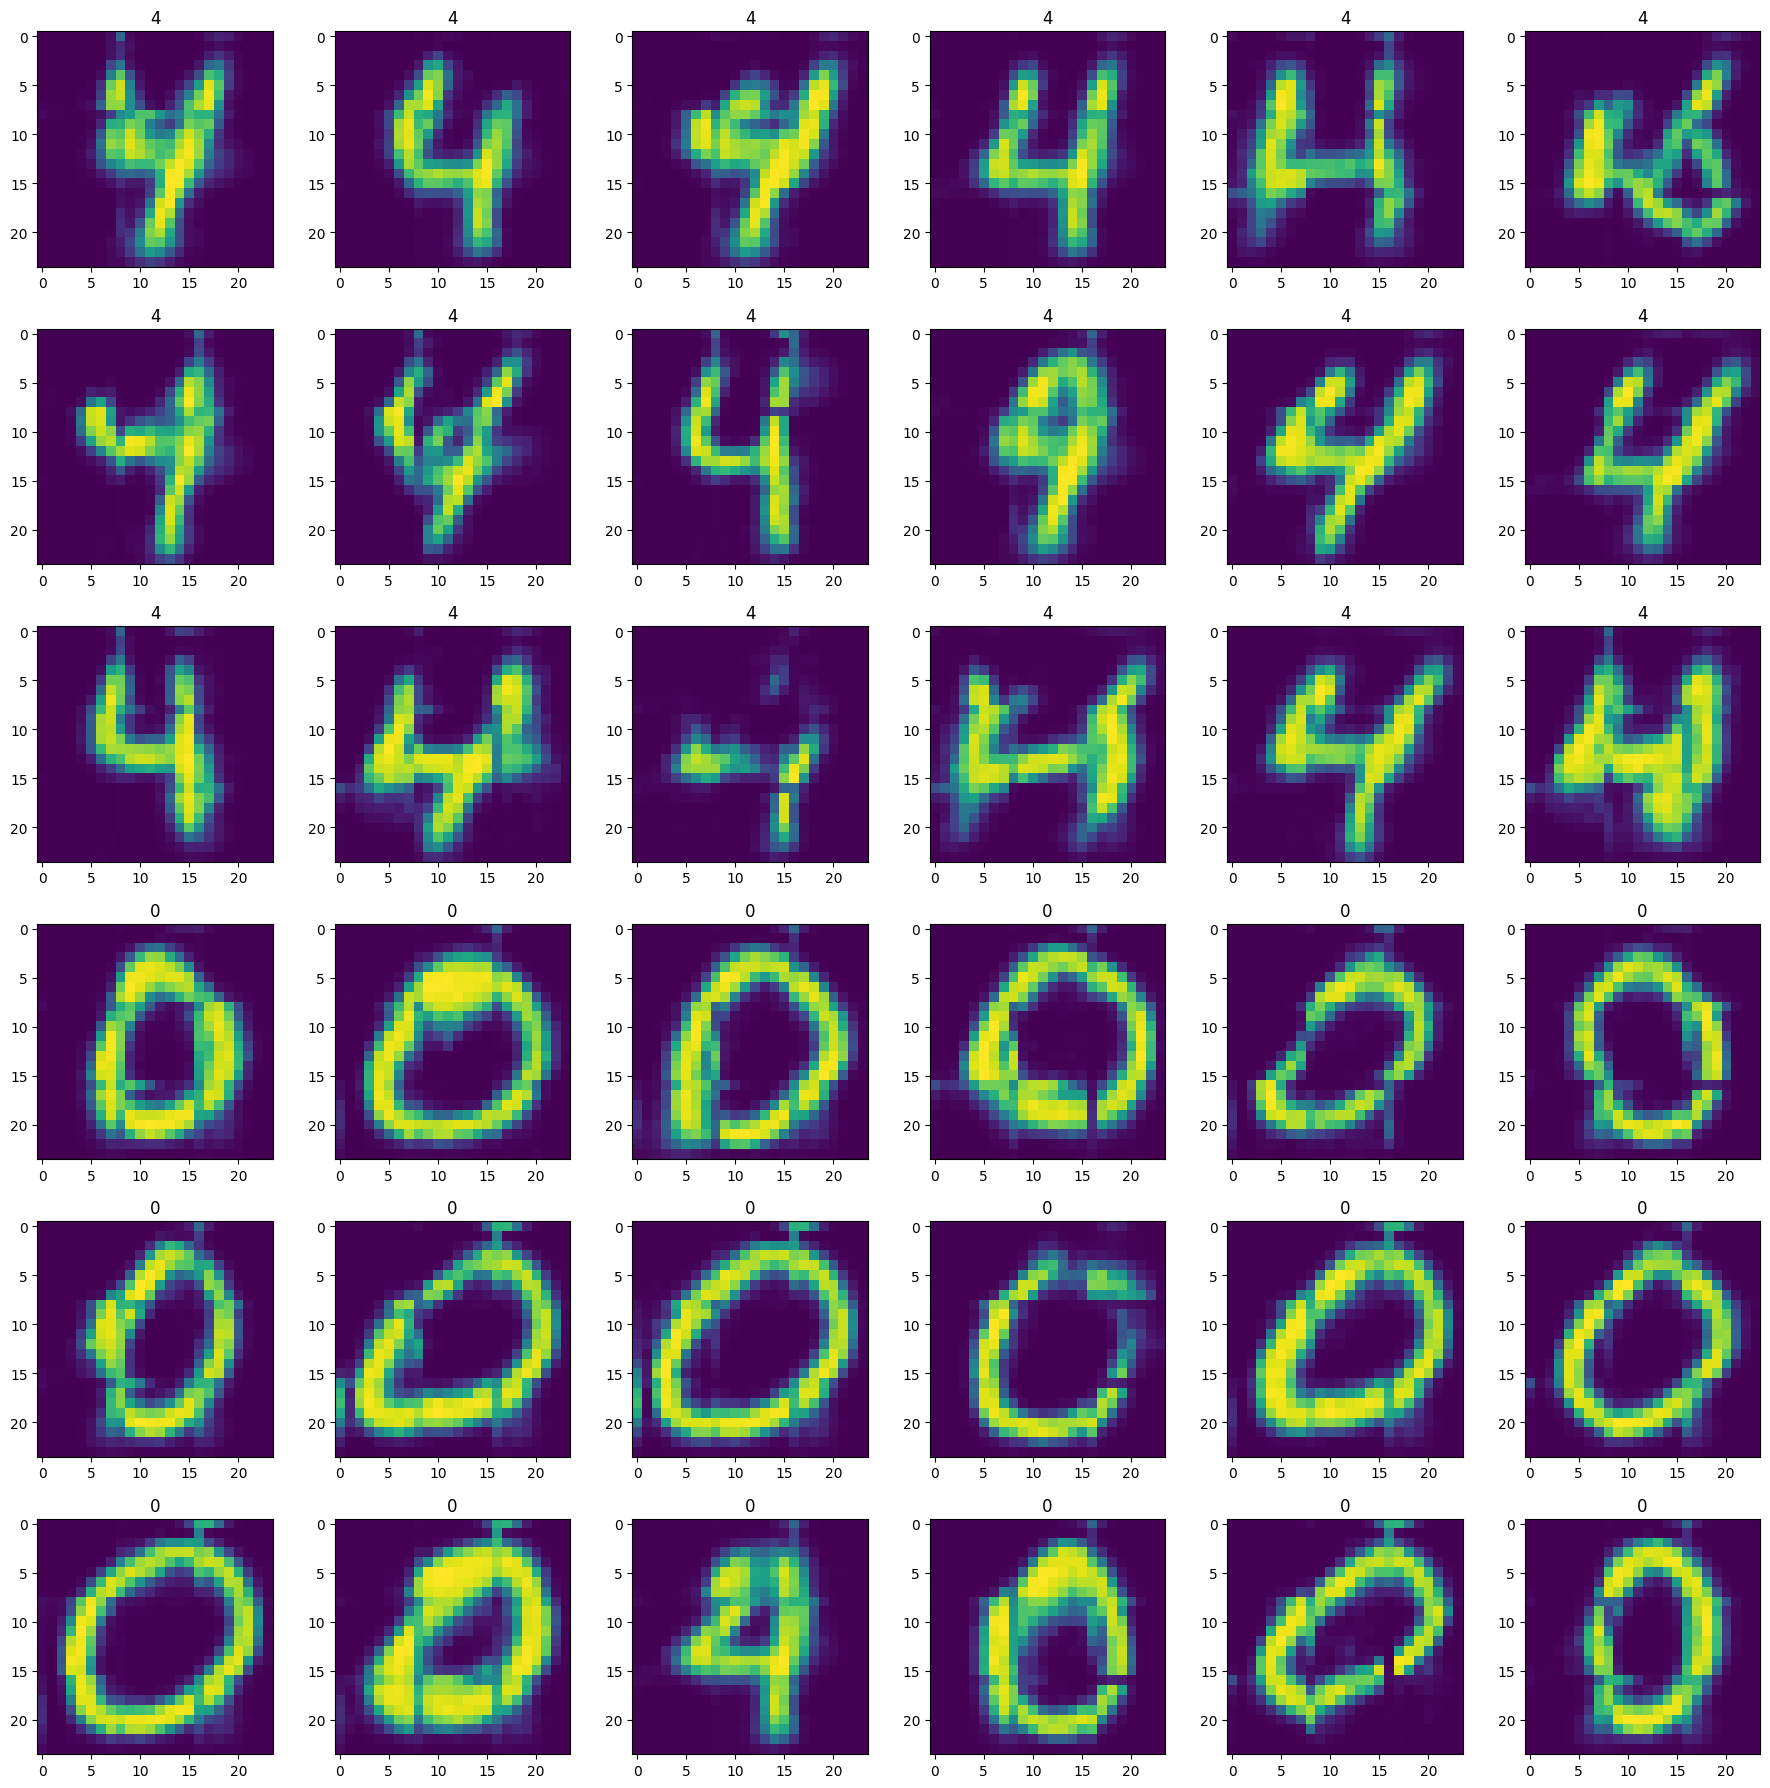

In [ ]:
inv = pca.inverse_transform(x_s).reshape(n_samples, *latent.shape[1:])
batch = torch.tensor(inv, dtype = torch.float32).to(DEVICE)
img, _, _ = model.decode(batch)

img = img.detach().cpu().numpy()
r_n = np.sqrt(img.shape[0]).astype(int)
fig, ax = plt.subplots(r_n, r_n, figsize = (18, 18))
fig.tight_layout()
for a, img, label in zip(ax.flatten(), img, y_s):
  a.imshow(img.squeeze())
  a.set_title(label)
plt.show()

As we can see new generated data is similar to orginal one. Some cases are not perfect but maybe with more complicated model they would be.